# Transfer Learning for Computer Vision

## Пункт 1. Изучение туториала

Для работы с безлайном большинство кода будет задействовано с сайта, поэтому комментирование кода будет производиться по ходу работы. Если говорить о содержании туториала, то в нём очень хорошо и понятно объясняется, как обучить свою свёрточную сеть (ConvNet/CNN) для классификации изображений с помощью трансферного обучения.

Глубокие нейронные сети требовательны к большим объемам данных для сходимости обучения. И зачастую в нашей частной задаче недостаточно данных для того, чтобы хорошо натренировать все слои нейросети. Transfer Learning решает эту проблему.

Рассмотрим кратко главы, которые представлены в туториале:

**1. Load Data**: загрузка данных с помощью пакетов torchvision и torch.utils.data. Выбранный в примере датасет включал в себя изображения муравьёв и пчёл. Обученная модель должна была по картинке опредлять, какое насекомое представлено на изображении. Также данная часть статьи включает в себя функции демонстрации изображений.

**2. Training the model**: здесь происходит демонтрация функции, с помощью которой далее модель будет обучаться. Затем определяется функция для демонстрации результатов лучшей модели

**3. Finetuning the ConvNet**: на данном этапе объявляются все необхожимые инструменты для обучения и их параметры: оптимизатор, шедулер, функция ошибки и другое. После обучения модели сохраняются показатели, давшие лучший результат.

**4. ConvNet as fixed feature extractor**: происходит заморозка всех слоёв сети кроме последнего. После этого происходит снова обучение модели с помощью немного изменнённого алгоритма.

**5. Inference on custom images**: демонстрация работы с обученной моделью на произвольно взятой картинке из стороннего источника.

Перейдём же непосредственно к реализации данного алгоритма.


Подлючаем все необходимые библиотеки для работы с данными

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

## Пункт 2. Выбор набора данных

Мною был выбран датасет с дорожными знаками. Каждый класс в нём обозначает определённый знак ограничения скорости. Датасет довольно актуальный в наше время, так как создан для решения реальных практических задач: обучение искусственного интеллекта соблюдать правила движения при управлении автомобилями.

Здесь происходит извлечение и нормализация данных для обучения. Данные заранее разделены на тренировочную и валидационную выборки.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/archive'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Напишем функцию для иллюстрации изображений из нашего датасета. Выведем примеры картинок и их принадлежность к конкретному классу.

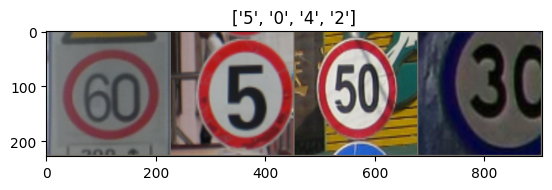

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)   # небольшая пауза для обновления графиков

# Получаем пакет обучающих данных
inputs, classes = next(iter(dataloaders['train']))

# Создание сетки из данных
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Пункт 3. Выбор метрики качества

Чтобы оценить качество модели, будем пользоваться метрикой accuracy. Данная метрика довольно проста в понимании: показывает долю правильных ответов. В целом, в нашей задаче все классы равны (по распределению), поэтому взятие данной метрики как метрики качества никак отрицательно не скажется на оценку эффективности работы модели.

## Пункт 4. Создание безлайна

Напишем функцию для обучения модели. Как раз здесь и будет происходить поиск лучшего набора параметров.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Создание временного каталога для хранения контрольных точек при обучении
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Обучение и оценка на каждой эпохе
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Перевод модели в режим обучения
                else:
                    model.eval()   # Перевод модели в режим оценки

                running_loss = 0.0
                running_corrects = 0

                # Итерирование по данным
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Обнуление параметров градиента
                    optimizer.zero_grad()

                    # Шаг вперёд градиента
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Статистика
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Сохранение лучших весов модели
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Функция для визуализации работы лучшей модели

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Подготавливаем все необходимые параметры для обучения модели: шедулер, оптимизатор, критерий, и другое

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучаем нашу модель. Используем для этих целей ГПУ, чтобы сэкономить время.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4945 Acc: 0.4150
val Loss: 0.8051 Acc: 0.8070

Epoch 1/24
----------
train Loss: 1.1803 Acc: 0.5620
val Loss: 0.7596 Acc: 0.6316

Epoch 2/24
----------
train Loss: 1.1109 Acc: 0.5881
val Loss: 0.8060 Acc: 0.6842

Epoch 3/24
----------
train Loss: 1.0716 Acc: 0.6257
val Loss: 0.6723 Acc: 0.7719

Epoch 4/24
----------
train Loss: 1.0274 Acc: 0.6246
val Loss: 0.6981 Acc: 0.7895

Epoch 5/24
----------
train Loss: 0.9822 Acc: 0.6340
val Loss: 0.4900 Acc: 0.8421

Epoch 6/24
----------
train Loss: 0.8908 Acc: 0.6757
val Loss: 0.6868 Acc: 0.7193

Epoch 7/24
----------
train Loss: 0.7356 Acc: 0.7299
val Loss: 0.5365 Acc: 0.8070

Epoch 8/24
----------
train Loss: 0.7598 Acc: 0.7185
val Loss: 0.4404 Acc: 0.8947

Epoch 9/24
----------
train Loss: 0.7300 Acc: 0.7351
val Loss: 0.4590 Acc: 0.8421

Epoch 10/24
----------
train Loss: 0.7638 Acc: 0.7258
val Loss: 0.4437 Acc: 0.8596

Epoch 11/24
----------
train Loss: 0.7181 Acc: 0.7372
val Loss: 0.4582 Acc: 0.8772

Ep

**Оценка качества:** как видим, модель дала весьма неплохие результаты - почти 90% правильно предсказанных результатов на валидационной выборке.

Продемонстрируем наглядно работу лучшей модели

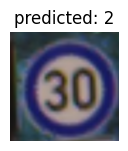

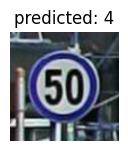

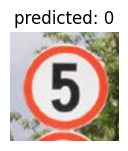

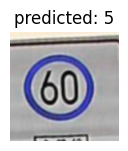

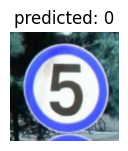

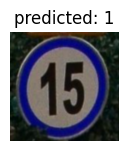

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

## Пункт 5. Улучшение безлайна

Попробуем улучшить показатели нашей модели. Для этого воспользуемся аугментацией: "заморозим" все слои сети, кроме последнего. Посмотрим, к чему преведёт данное решение.

Задаём новые параметры модели. В этот раз установим require_grad = False, чтобы заморозить параметры. В таком случае градиенты не будут вычислятсья в Back().

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Снова обучаем нашу модель

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0691 Acc: 0.6423
val Loss: 0.1685 Acc: 0.9298

Epoch 1/24
----------
train Loss: 0.7311 Acc: 0.7737
val Loss: 0.0462 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.4768 Acc: 0.8384
val Loss: 0.3535 Acc: 0.9298

Epoch 3/24
----------
train Loss: 0.4081 Acc: 0.8613
val Loss: 0.0473 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2986 Acc: 0.9030
val Loss: 0.0324 Acc: 0.9825

Epoch 5/24
----------
train Loss: 0.3708 Acc: 0.8780
val Loss: 0.0031 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3338 Acc: 0.8999
val Loss: 0.0082 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2526 Acc: 0.9114
val Loss: 0.0016 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2451 Acc: 0.9124
val Loss: 0.0020 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2767 Acc: 0.9030
val Loss: 0.0015 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1877 Acc: 0.9312
val Loss: 0.0016 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2003 Acc: 0.9301
val Loss: 0.0043 Acc: 1.0000

Ep

**Сравнение с результатами из пункта 4 и формирование выводов:** как видим, новый метод обучения дал безупречные результаты: все картинки были правильно распределены по классам на валидационно выборке. Причина того, что "заморозка" слоёв сработала успешно, скорее всего кроется в выбранном мною датасете. Признаки, по котором оцениваются изображения, здесь не очень сложные, поэтому дообучивание предыдущих слоёв приводит к тому, что такие признаки обнаруживаются значительно лучше.

## Пункт 6. Реализация нейросетевой архитектуры

Реализуем самостоятельно нейросетевую архитектуру, которая также позволит решать задачу классификации объектов. Выберем для этих целей архитектуру ResNet18 от Microsoft Labs, которая в своё время выиграла конкурс ImageNet.

Специалисты отмечают, что глубокие стопки свёрточных слоёв приводят к сильному затуханию градиента, а как следствие, к плохой обучаемости. Чтобы решить эту проблему, они ввели "остаточные" (residual) пути по которым градиенту при обратном распространении легче проходить. В результате, даже сети с 1000 слоями достаточно успешно учатся, приводя к дополнительному улучшению точности модели.

ResNet-18 - это сверточная нейронная сеть глубиной 18 слоев. Можно загрузить предварительно подготовленную версию сети, обученную на более чем миллионе изображений из базы данных ImageNet. Предварительно обученная сеть может классифицировать изображения по 1000 категориям объектов, таким как клавиатура, мышь, карандаш и множество животных. В результате сеть изучила богатые представления объектов для широкого спектра изображений. Размер входного изображения в сети составляет 224 на 224.

Если углубляться в суть, то ResNets применяет сопоставление идентификаторов между уровнями для достижения архитектуры сокращенных соединений. А уровни/блоки в архитектуре, состоящие из этих сокращенных соединений, известны как блоки остаточного обучения.

Рисунок ниже более конкретно описывает суть данной архитектуры:


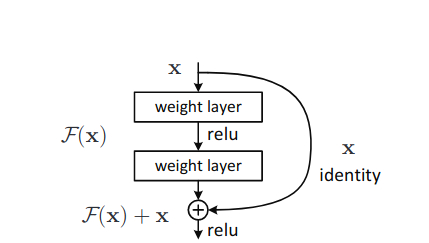

Перейдём к реализации. Данная архитектура строится из блоков, поэтому их можно описать в отдельном классе *BasicBlock*:

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=(1 + (in_channels != out_channels)),
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=2, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(x + out)

Класс самой сети, которая будет обучать нашу модель:

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=1000):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(block(64, 64), block(64, 64))
        self.layer2 = nn.Sequential(block(64, 128), block(128, 128))
        self.layer3 = nn.Sequential(block(128, 256), block(256, 256))
        self.layer4 = nn.Sequential(block(256, 512), block(512, 512))

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return self.fc(x.flatten(1))

Далее задаём параметры модели:

In [ ]:
my_model_ft = ResNet18(num_classes=len(class_names))

my_model_ft = my_model_ft.to(device)

SGD лучше всего подходит для обучения ResNet-18

In [ ]:
my_optimizer_ft = optim.SGD(
    my_model_ft.parameters(),
    lr=0.001,
    weight_decay= 0.0001,
    momentum=0.9,
)

CosineAnnealingLR изменяет шаг обучения по косинусу

In [ ]:
my_cos_lr_scheduler = lr_scheduler.CosineAnnealingLR(my_optimizer_ft, T_max=25)

Обучаем нашу модель

In [ ]:
my_model_ft = train_model(
    my_model_ft, criterion, my_optimizer_ft, my_cos_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 1.7963 Acc: 0.2909
val Loss: 2.8820 Acc: 0.1053

Epoch 1/24
----------
train Loss: 1.6904 Acc: 0.3233
val Loss: 2.7007 Acc: 0.2456

Epoch 2/24
----------
train Loss: 1.4736 Acc: 0.4213
val Loss: 1.7739 Acc: 0.2632

Epoch 3/24
----------
train Loss: 1.4112 Acc: 0.4056
val Loss: 1.6773 Acc: 0.3333

Epoch 4/24
----------
train Loss: 1.2967 Acc: 0.4891
val Loss: 1.2815 Acc: 0.5789

Epoch 5/24
----------
train Loss: 1.2015 Acc: 0.5370
val Loss: 1.5866 Acc: 0.4561

Epoch 6/24
----------
train Loss: 1.1568 Acc: 0.5474
val Loss: 0.8745 Acc: 0.6842

Epoch 7/24
----------
train Loss: 0.9548 Acc: 0.6236
val Loss: 1.7307 Acc: 0.3860

Epoch 8/24
----------
train Loss: 0.9199 Acc: 0.6736
val Loss: 1.0761 Acc: 0.5439

Epoch 9/24
----------
train Loss: 0.7389 Acc: 0.7289
val Loss: 1.7137 Acc: 0.4912

Epoch 10/24
----------
train Loss: 0.6618 Acc: 0.7602
val Loss: 0.6834 Acc: 0.7193

Epoch 11/24
----------
train Loss: 0.6322 Acc: 0.7706
val Loss: 0.2758 Acc: 0.9123

Epoch 12/24
----------
t

**Сравнение результатов:** судя по результатам, лучшая модель, полученная с помощью архитектуры ResNet18, справляется с задачей также, как и свёрточные сети из предыдущего пункта.

Продемонстрируем наглядно работу лучшей модели

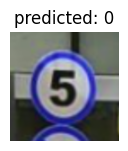

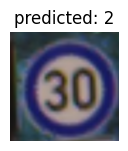

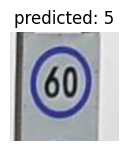

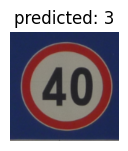

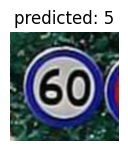

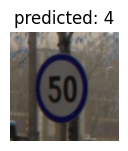

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

**Вывод:** работа с Transfer Learning в компьютерном зрении показалась довольно интересной и удобной в данной лабораторной работе. Простота пользования позволяет применять данный алгоритм любому простому человеку, который не является специалистом в данной сфере, для своих личных целей. При этом, качество работы модели, полученной в процессе обучения, впечатляет. Что же касается архитектуры ResNer18, то с поставленной задачей она справляется также хорошо, как и сверточные сети из прошлого метода, но требуют более деликатного и серьёзного подхода к задаче. Также не исключаю того факта, что подобранный мною датасет очень хорошо подходит для обеих нейросетевый архитектур, из-за чего результаты оказались безупречными.